In [34]:
pip install azure.cognitiveservices.vision.customvision

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install opencv-contrib-python --user

Note: you may need to restart the kernel to use updated packages.


In [1]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
import matplotlib.pyplot as plt
from msrest.authentication import ApiKeyCredentials

import json
import cv2

%matplotlib inline

# Endpoint and key definition for Azure Custom Vision API

In [2]:
configfile = open("config.txt",'r')
read = configfile.read()
for line in read.splitlines():
    if "ENDPOINT" in line:
        ENDPOINT = line.split("=",1)[1]
    if "training_key" in line:
        training_key = line.split("=",1)[1]
    if "prediction_key" in line:
        prediction_key = line.split("=",1)[1]
    if "training_resource_id" in line:
        training_resource_id = line.split("=",1)[1]
    if "prediction_resource_id" in line:
        prediction_resource_id = line.split("=",1)[1]    

In [3]:
credentialsTrain   = ApiKeyCredentials(in_headers={"Training-key":   training_key})
train   = CustomVisionTrainingClient  (ENDPOINT, credentialsTrain)
credentialsPredict = ApiKeyCredentials(in_headers={"prediction-key": prediction_key})
predict = CustomVisionPredictionClient(ENDPOINT, credentialsPredict)

projects = train.get_projects()
project = None

for p in projects:
    if p.name == "Wildlife":
        project = p
iterations = train.get_iterations(project.id)

# Helper functions for plotting

In [47]:
def append_predictions(result, confindence_level = CONFIDENCE):
    predictions = []
    for prediction in result.predictions:
        y1 = int(prediction.bounding_box.top * 720)
        
        if (prediction.probability > confindence_level) and (y1>150):
            predictions.append(prediction)            
    return predictions

# Adds border box and text on images based off predictions
# Custom Vision gives bounding box as noramlized coordinates 
# so they need to be computed to X, Y, Width, and Height that
# Open CV uses
def add_boxes_to_images(img, predictions):
    for pred in predictions:
        x =      int(pred.bounding_box.left   *  img.shape[1])
        y =      int(pred.bounding_box.top    *  img.shape[0])
        x2 = x + int(pred.bounding_box.width  *  img.shape[1])
        y2 = y + int(pred.bounding_box.height *  img.shape[0])
        
        img = cv2.rectangle(img, (x,y), (x2,y2), (0,0,255), 2)
        img = cv2.putText(img, pred.tag_name, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 1, cv2.LINE_AA, False)

def show_inline_img(img):
    inline_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,20))
    plt.axis("off")
    plt.imshow(inline_img)

def showpicture(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    #img = cv2.resize(img,(400,400))    
    show_inline_img(img)
    
def showpicture_with_boxes(path):
    image = cv2.imread(path)
    with open(path, mode="rb") as image_data:
        cow_result = predict.detect_image(project.id, "Iteration1", image_data)
    predictions = append_predictions(cow_result)
    add_boxes_to_images(image,predictions)
    show_inline_img(image)
    

# Parse and explode the video file into JPEGs 

In [5]:
import json
import glob
import math
import os
import shutil
from IPython.display import clear_output, Image, display, Video
import urllib.request
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [41]:
input_video = "C:/Users/benno/Documents/Coursera_Courses/CustomVisionWildlifeCounter/notebooks/cows1_short.mp4"  # The input video
START_LINE = 0 
FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
FRAMES_DIR_TEST = "frames/test"
OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
OUTPUT_TEST_DIR = "output/test"
SAMPLING = 10  # Classify every n frames (use tracking in between)
CONFIDENCE = 0.29  # Confidence threshold to filter iffy objects

# OpenCV colors are (B, G, R) tuples -- RGB in reverse
WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)

In [1]:
#Video(input_video,embed=True) #You can watch the video here but that makes the notebook file huge

In [7]:
FRAMES_DIR = "C:/Users/benno/Documents/Coursera_Courses/CustomVisionWildlifeCounter/notebooks/FRAMES"
OUTPUT_DIR = "C:/Users/benno/Documents/Coursera_Courses/CustomVisionWildlifeCounter/notebooks/OUTPUT"
if not os.path.isdir(FRAMES_DIR):
    os.mkdir(FRAMES_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [8]:
if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count estimate is %d" % total_frames)

Frame count estimate is 623


In [16]:
num = 0
while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
        print("Writing frame {num} of {total_frames}".format(
            num=num, total_frames=total_frames), end="\r")
        cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
            num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num))

Frame count estimate is 623
Writing frame 623 of 623
Wrote 623 frames


# Test Custom Vision API on single image

0.872479737 Cow {'additional_properties': {}, 'left': 0.013046816, 'top': 0.6300193, 'width': 0.04915753, 'height': 0.054988265}


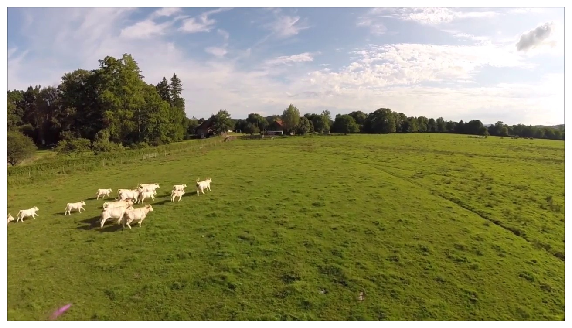

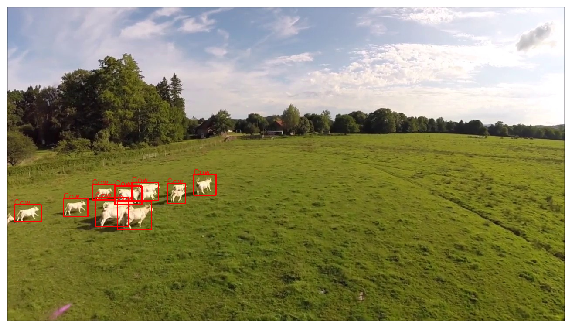

In [48]:
image_path =  "C:/Users/benno/Documents/Coursera_Courses/CustomVisionWildlifeCounter/notebooks/FRAMES/frame_00158.jpg"
image_path =  "C:/Users/benno/Documents/Coursera_Courses/CustomVisionWildlifeCounter/notebooks/FRAMES/frame_00437.jpg"
#image_path = "FRAMES/frame_00087.jpg"

img = cv2.imread(image_path)

with open(image_path, mode="rb") as image_data:
    cow_result = predict.detect_image(project.id, "Iteration1", image_data)
print(cow_result.predictions[0].probability, cow_result.predictions[0].tag_name, cow_result.predictions[0].bounding_box)

predictions = append_predictions(cow_result)

showpicture(image_path) 

add_boxes_to_images(img,predictions)
show_inline_img(img)

# Detect cows in frames from Video / Inference, tracking, and annotation

# Write labeled Outputframes as files

In [49]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(FRAMES_DIR),
                                              'frame_*.jpg'))):
    filename = filename.replace("\\","/")
    
    with open(filename, mode="rb") as image_data:
        cow_result = predict.detect_image(project.id, "Iteration1", image_data)
    
    predictions = append_predictions(cow_result)

    frame = cv2.imread(filename)
    add_boxes_to_images(frame,predictions)
    cv2.imwrite(os.path.join(os.path.abspath(OUTPUT_DIR),filename.rsplit('/')[-1]),frame)
    
    

# Play Output frames in notebook (no counting yet)

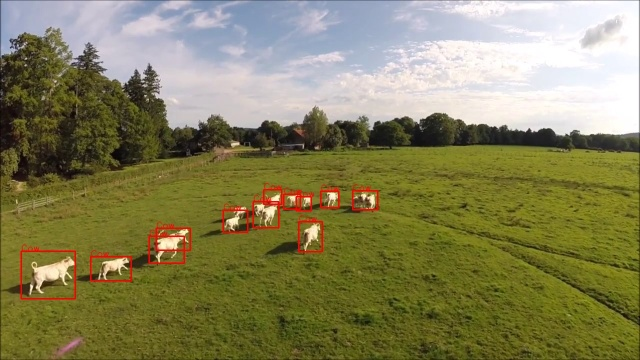


Done


In [50]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

print("\nDone")

# PART 2: Follow objects and counting

In [16]:
def detect_objects(filename):
    img = cv2.imread(filename)
    data = {}
    with open(filename, mode="rb") as image_data:
        cow_result = predict.detect_image(project.id, "Iteration1", image_data)
        predictions = append_predictions(cow_result)
        data["classified"] = []
        for pred in predictions:
            data["classified"].append({
                "confindence": str(pred.probability),        
                "label": str(pred.tag_name),
                "x1":  str(int(pred.bounding_box.left   * img.shape[1])),
                "y1":  str(int(pred.bounding_box.top    * img.shape[0])),
                "x2":  str(int(pred.bounding_box.left   * img.shape[1]) + int(pred.bounding_box.width  * img.shape[1])),
                "y2":  str(int(pred.bounding_box.top    * img.shape[0]) + int(pred.bounding_box.height * img.shape[0])),
            })
    json_data = json.dumps(data)
    json_objects = json.loads(json_data)
    return json_objects    

## Test API on single frame and return JSON Output

In [17]:
testframepath = "FRAMES/frame_00161.jpg"
jsonresp = detect_objects(testframepath)
print("jsonresp: %s" % jsonresp)
if testframepath in jsonresp:
    print("Got back objects:"+  str(len(jsonresp['classified'])))
#print(json.dumps(jsonresp, indent=2))
print("Got back objects:"+  str(len(jsonresp['classified'])))

jsonresp: {'classified': [{'confindence': '0.8247816', 'label': 'Cow', 'x1': '49', 'y1': '413', 'x2': '107', 'y2': '460'}, {'confindence': '0.666659355', 'label': 'Cow', 'x1': '7', 'y1': '374', 'x2': '44', 'y2': '410'}, {'confindence': '0.389978766', 'label': 'Cow', 'x1': '0', 'y1': '417', 'x2': '16', 'y2': '452'}, {'confindence': '0.240664408', 'label': 'Cow', 'x1': '1131', 'y1': '7', 'x2': '1247', 'y2': '118'}]}
Got back objects:4


In [51]:
# Serialize requests, storing them in a "tracking_results" dict

try:
    with open('frames/frame-data-newmodel.json') as existing_results:
        tracking_results = json.load(existing_results)
except Exception:
    # Any fail to read existing results means we start over
    tracking_results = {}

print("Sampling every %sth frame" % SAMPLING)
i = 0
cache_used = 0
sampled = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    #print(filename)
    filename = filename.replace("\\","/")
    i += 1

    if not i % SAMPLING == 0:  # Sample every Nth
        continue
    existing_result = tracking_results.get(filename)
    if existing_result:
        cache_used += 1
    else:
        results = detect_objects(filename)
        sampled += 1
        # Save frequently to cache partial results
        tracking_results[filename] = results         
        with open('frames/frame-data-newmodel.json', 'w') as fp:
            json.dump(tracking_results, fp)

    print("Processed file {num} of {total_frames} (used cache {cache_used} times)".format(
        num=i, total_frames=total_frames, cache_used=cache_used), end="\r")

# Finally, write all our results
with open('frames/frame-data-newmodel.json', 'w') as fp:
    json.dump(tracking_results, fp)

print("\nDone")

Sampling every 10th frame
Processed file 620 of 623 (used cache 0 times)
Done


# Helper functions for tracking and labeling

In [25]:
def label_object(color, textcolor, fontface, image, cow, textsize, thickness, x2, xmid, x1, y2, ymid, y1):
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 2)
    pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
    cv2.putText(image, cow, pos, fontface, 1, textcolor, thickness, cv2.LINE_AA)


def update_trackers(image, counters):
    in_sight = counters['in_sight']
    lost_cows = counters['lost_cows']
    boxes = []
    color = (80, 220, 60)
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1

    for n, pair in enumerate(trackers):
        tracker, cow = pair
        textsize, _baseline = cv2.getTextSize(
            cow, fontface, fontscale, thickness)
        success, bbox = tracker.update(image)
        if not success:
            counters['lost_cows'] += 1
            del trackers[n]
            continue

        boxes.append(bbox)  # Return updated box list

        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[0] + bbox[2])
        y2 = int(bbox[1] + bbox[3])
        xmid = int(round((x1+x2)/2))
        ymid = int(round((y1+y2)/2))

        if ymid < ROI_YMAX:
            label_object(color, YELLOW, fontface, image, cow, textsize, 4, x2, xmid, x1, y2, ymid, y1)
        
    # Add finish line overlay/line
    overlay = image.copy()

    
    return boxes, counters

In [26]:
def not_tracked(objects, boxes):
    if not objects:
        return []  # No new classified objects to search for
    if not boxes:
        return objects  # No existing boxes, return all objects

    new_objects = []
    for obj in objects:
        y1 = int(obj.get("y1", ""))
        y2 = int(obj.get("y2", ""))
        ymid = int(round((y1+y2)/2))
        x1 = int(obj.get("x1", ""))
        x2 = int(obj.get("x2", ""))
        xmid = int(round((x1+x2)/2))
        box_range = ((x2 - x1) + (y2 - y1)) / 2
        for bbox in boxes:
            bx1 = int(bbox[0])
            by1 = int(bbox[1])
            bx2 = int(bbox[0] + bbox[2])
            by2 = int(bbox[1] + bbox[3])
            bxmid = int((bx1 + bx2) / 2)
            bymid = int((by1 + by2) / 2)
            if math.sqrt((xmid - bxmid)**2 + (ymid - bymid)**2) < box_range:
                # found existing, so break (do not add to new_objects)
                break
        else:
            new_objects.append(obj)

    return new_objects

In [27]:
def in_range(obj):
    y1 = obj['y1']
    y2 = obj['y2']
    if int(y1) > ROI_YMAX or int(y2) > ROI_YMAX:
        return False
    return True
    
def add_new_object(obj, image, cows):
    cow = str(cows)
    
    x1 = int(obj['x1'])
    y1 = int(obj['y1'])
    x2 = int(obj['x2'])
    y2 = int(obj['y2'])    
    xmid = int(round((x1+x2)/2))
    ymid = int(round((y1+y2)/2))

    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1
    textsize, _baseline = cv2.getTextSize(
        cow, fontface, fontscale, thickness)

    tracker = cv2.TrackerKCF_create()  # Note: Try comparing KCF with MIL
    success = tracker.init(image, (x1, y1, x2-x1, y2-y1))
    
    if success:
        trackers.append((tracker, cow))
        
    label_object(GREEN, YELLOW, fontface, image, cow, textsize, 4, x2, xmid, x1, y2, ymid, y1)

# Inference, tracking, and annotation

Loop through the saved frames and:

* Update the trackers to follow already detected objects from frame to frame.
* Look for new objects if we ran inference on this frame.
    * Check for overlap with tracked objects.
    * If no overlap, assign a sequence number and start tracking.
* Write an annotated image with tracked objects highlighted and numbered.

In [52]:
FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
ROI_YMAX = FRAME_HEIGHT # if box is in sight 
ROI_XMAX = FRAME_WIDTH

print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))
cows = 0
trackers = []
counters = {
    'in_sight':  0,
    'lost_cows': 0,
    'frames': 0,
}

 
with open('frames/frame-data-newmodel.json') as existing_results:
    tracking_results = json.load(existing_results)
    #print(tracking_results)
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    filename = filename.replace("\\","/")
    counters['frames'] += 1
    img = cv2.imread(filename)
    boxes, counters = update_trackers(img, counters)
    #print(filename+': '+str(len(boxes)))
    
    if filename in tracking_results and 'classified' in tracking_results[filename]:
        jsonresp = tracking_results[filename]
        for obj in not_tracked(jsonresp['classified'], boxes):
            #cows = cows - counters['lost_cows']
            if in_range(obj):
                #cows += 1                
                add_new_object(obj, img, cows)  # Label and start tracking
    cows = len(boxes)       
    # Draw the running total of cows in the image in the upper-left corner
    cv2.putText(img, 'Cows in sight: ' + str(cows), (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, DARK_BLUE, 4, cv2.LINE_AA)
    # Add note with count of trackers lost
    cv2.putText(img, 'Cows lost: ' + str(counters['lost_cows']), (35, 85),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, DARK_BLUE, 1, cv2.LINE_AA)

    cv2.imwrite("output/output_" + filename.split('/')[-1], img)
    print("Processed file {num} of {total_frames}".format(
        num=counters['frames'], total_frames=total_frames), end="\r")
    
print("\nDone")

Frame Dimensions: 1280x720
Processed file 623 of 623
Done


# Play annotated frames in notebook

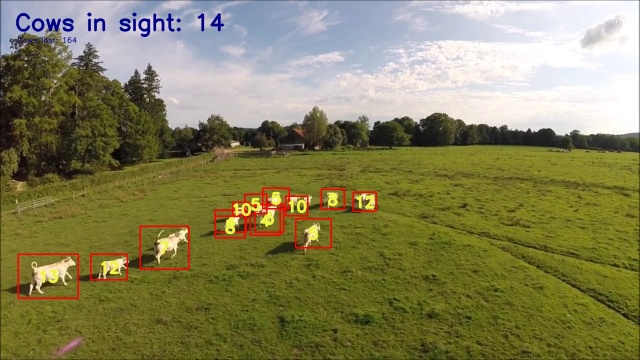


Done


In [53]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'output_frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

print("\nDone")